# Regression Analysis on PH Data



We want to use Ordinary Least Squares (OLS) regression on the relationships between likes, dislikes and views in comparison with the sentiment of the tags used as well as the video title.

I believe the main goal here is to find (and plot) the relationships for both positive and negative tags through the above methods, then to compare them. Ultimately what we are trying to answer is which relationship is stronger, represented by the question: 'Do negative sentiment tags result in more views, likes and dislikes than trans videos with positive tags?'

To answer this we can use the sample I generated for the last checkpoint, which contains 100,000+ rows of only trans-related videos. In this notebook will be a block of code for quantizing the sentiment of each video's title and tags combined.

For context, the rules of whether a video has positive or negative connotations is: 
- If even one derogatory tag is included, the video will be labelled as negative.
- If all tags for a video are positive or unrelated, then it will be labelled as positive.
- This is based on lists of words I created, not on sentiment analysis; this is because sentiment analysis libraries do not include many derogatory terms used against trans people. With that said, if you would like to change the rules/refine the system then feel free!

It is also worth testing other methods of analysis if OLS does not seem to fit well with the question.

### Importing tools

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats

# Testing sentiment analysis, will be adding words to the database
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jackson\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Loading csv and quantizing sentiment column

In [42]:
# Change the path to your own
df = pd.read_csv('~\Documents\phdb\PhDataFiltered.csv')
df.head()

,Unnamed: 0,cleaned_title,tag_list,Categories,views,likes,dislikes,Title,Tags
0,0,"['transsexual', 'heartbreakers', 'scene']","['pornhub.com', 'blonde', 'milf', 'beauty', 't...",transgender,71525,284.0,33.0,transsexual heartbreakers 19 - scene 5,pornhub.com;blonde;milf;beauty;tranny;anal;ass...
1,1,"['big', 'tit', 'trannys', 'scene']","['pornhub.com', 'shemale', 'lady-boy', 'tranny...",transgender,11896,26.0,11.0,big tit trannys - scene 3,pornhub.com;shemale;lady-boy;tranny;transsexua...
2,2,"['unsafe', 'sex', 'transsexual', 'barebackin',...","['pornhub.com', 'tranny', 'strip', 'small-tits...",transgender,18339,58.0,9.0,unsafe sex with transsexual barebackin 1 - sce...,pornhub.com;tranny;strip;small-tits;brunette;l...
3,3,"['transsexual', 'heartbreakers', 'scene']","['pornhub.com', 'she-male', 'blonde', 'latina'...",transgender,47759,162.0,42.0,transsexual heartbreakers 8 - scene 4,pornhub.com;she-male;blonde;latina;transsexual...
4,4,"['sluts', 'packing', 'nuts', 'scene']","['pornhub.com', 'shemale', 'stockings', 'trann...",transgender,9803,19.0,7.0,sluts packing nuts 5 - scene 1,pornhub.com;shemale;stockings;tranny;tanlines;...


In [43]:
# Dropping unnecessary columns
df = df.drop('Unnamed: 0', axis = 1)
df = df.drop('Title', axis = 1)
df = df.drop('Tags', axis = 1)
df = df.drop('Categories', axis = 1)
df.columns

Index(['cleaned_title', 'tag_list', 'views', 'likes', 'dislikes'], dtype='object')

In [44]:
# Initializing word lists. Feel free to expand if you know more examples
neg_tags = ['shemale', 'tranny', 'sissy', 'ladyboy', 'trap', 'transsexual', 'transexual', 'shemales', 'trannies', 'sissies', 'ladyboys', 'traps', 'troon', 'troons'] 
pos_tags = ['transgender', 'trans', 'transgirl', 'transboy', 'transman', 'ftm', 'mtf', 'transgirls', 'transboys']

In [45]:
# Creating a sentiment column according to the rules; 
# 0 = negative sentiment, 1 = positive sentiment

def determine_sentiment(title, tags):
    words = title + tags

    # Check for any negative word
    if any(neg_word in words for neg_word in neg_tags):
        return 0
    
    # If no negatives, check for positive words
    elif any(pos_word in words for pos_word in pos_tags):
        return 1
    # If none exist (should be impossible) assigns -1
    return -1

# Applying func
df['sentiment'] = df.apply(lambda row: determine_sentiment(row['cleaned_title'], row['tag_list']), axis=1)
df['sentiment'].value_counts()

sentiment
0    86405
1    29663
Name: count, dtype: int64

### At this point, only the likes, dislikes, views and sentiment columns should be necessary

### One question is, should sentiment be proportional? As in, a number between 0 and 1 that shows the balance between negative and positive tags
It is likely that using a binary variable for comparison causes regression to be ineffective

In [46]:
# Attempting the above. Closer to 1 is more positive, closer to 0 is more negative

def determine_sentiment_proportion(title, tags):
    words = title + tags

    # Summing occurances of words for each sentiment list
    positive_count = sum(pos_word in words for pos_word in pos_tags)
    negative_count = sum(neg_word in words for neg_word in neg_tags)
    total_count = positive_count + negative_count

    # Return a proportion of positive words over the total count
    # If there are no positive elements, the calculation will result in zero (indicating fully negative)
    # If only positive elements, it should return 1.0
    return positive_count / total_count

# Applying func
df['sentiment_proportion'] = df.apply(lambda row: determine_sentiment_proportion(row['cleaned_title'], row['tag_list']), axis=1)

df

,cleaned_title,tag_list,views,likes,dislikes,sentiment,sentiment_proportion
0,"['transsexual', 'heartbreakers', 'scene']","['pornhub.com', 'blonde', 'milf', 'beauty', 't...",71525,284.0,33.0,0,0.333333
1,"['big', 'tit', 'trannys', 'scene']","['pornhub.com', 'shemale', 'lady-boy', 'tranny...",11896,26.0,11.0,0,0.400000
2,"['unsafe', 'sex', 'transsexual', 'barebackin',...","['pornhub.com', 'tranny', 'strip', 'small-tits...",18339,58.0,9.0,0,0.333333
3,"['transsexual', 'heartbreakers', 'scene']","['pornhub.com', 'she-male', 'blonde', 'latina'...",47759,162.0,42.0,0,0.500000
4,"['sluts', 'packing', 'nuts', 'scene']","['pornhub.com', 'shemale', 'stockings', 'trann...",9803,19.0,7.0,0,0.000000
...,...,...,...,...,...,...,...
116063,"['crossdressing', 'model', 'anastasia', 'harri...","['anastasia-harris', 'crossdresser', 'sissy-cr...",51,0.0,0.0,0,0.666667
116064,"['destroying', 'bussy', 'huge', 'mr', 'hankey'...","['huge-dildo', 'huge-dildo-anal', 'huge-dildo-...",11,0.0,0.0,0,0.000000
116065,"['blonde', 'trap', 'stunner', 'karina', 'abelh...","['transsexual', 'shemale', 'tranny', 'blonde',...",135,1.0,0.0,0,0.200000
116066,"['slave', 'tranny']","['trans', 'tgirl', 'teaser', 'onlyfans-teaser'...",9,0.0,0.0,0,0.500000


### The sentiment_proportion column should be better suited for actually finding relationships, now we should be able to continue with analysis
Goals:
- Conduct sentiment analysis on tags and titles to generate another sentiment column to compare to our custom tailored sentiment column to see which is more accurate
    - Also look up if the libraries we use for sentiment analysis include the derogatory terms we are looking at, this is the important part
- Do OLS regression for views vs sentiment, likes vs sentiment, etc
    - Generate a graph to show all in one for readability; can likely be a bar graph or maybe a box plot
    - Consider the use of other regression algorithms for testing

- If results seem skewed, try to bring metrics to similar orders of magnitude
    - For example, scale views down to a decimal value to match sentiment proportion order of magnitude?

- Lastly, consider sampling a set of non-trans videos to run comparisons between the two
    - This requires the sentiment analysis to be accurate, as there is no comparable list of derogatory terms we could compile for non-trans videos without bias

Update: adding words to a sentiment lexicon is pretty infeasible, would need to learn the lexicon's rules, etc etc. time consuming

### Looking at the sentiment_proportion column, we can immediately see that outlier points with very high views/likes/dislikes almost only exist for videos with predominantly negative sentiment
### This suggests that a majority of viewers prefer derogatory tags, assuming the PornHub search algorithm does not promote derogatory terms (which it most likely does not based on the companies attitude)

### For T-Test purposes, we can divide our population based on sentiment_proportion; less than .5 is negative, more than .5 is positive

In [34]:
pos_df = df[df['sentiment_proportion'] > .5]
# Weighing in favor of negative sentiment by having it include .5
# This is based on the idea that the presence of any negative terms weighs the video's overall sentiment much more heavily due to the seriousness of derogatory terms
# Ideally, a vast majority of these videos would be marked as negative due to this reason
neg_df = df[df['sentiment_proportion'] <= .5]
s_pos = pos_df['sentiment_proportion']
s_neg = neg_df['sentiment_proportion']

Getting the ratios of negative and positive sentiment videos relative to total count

In [40]:
r_pos = pos_df.index.size/df.index.size
r_neg = neg_df.index.size/df.index.size
df.head()

,sentiment_proportion,logit_transformed
0,0.10,-2.197225
1,0.50,0.000000
2,0.90,2.197225
3,0.99,4.595120
4,0.01,-4.595120


In [47]:
# Adjusting 0 and 1 values slightly
df['sentiment_proportion'] = df['sentiment_proportion'].replace({0: 0.0001, 1: 0.9999})

# Applying the logit transformation
df['log_transformed'] = np.log(df['sentiment_proportion'] / (1 - df['sentiment_proportion']))

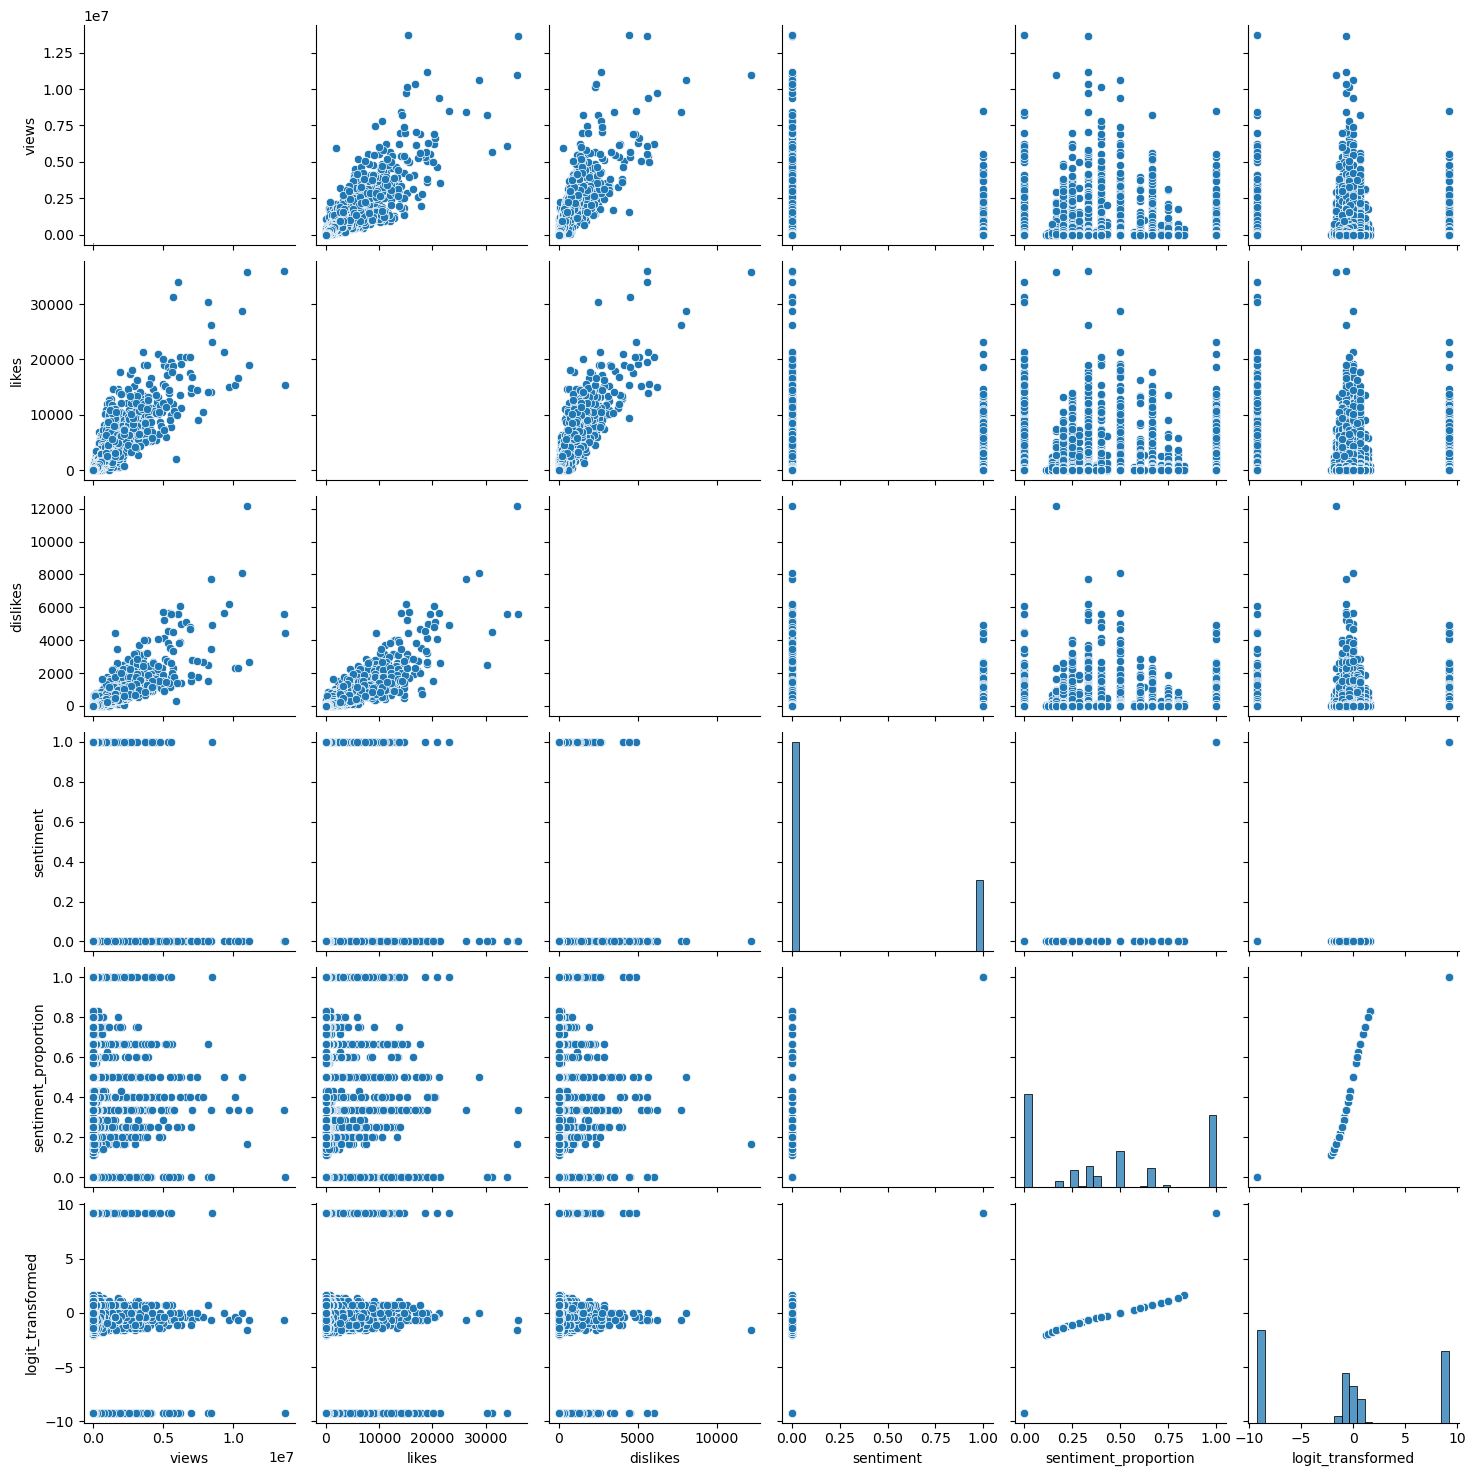

In [48]:
sns.pairplot(df)

Alright then how do we deal with those extremities?
Lets just try cutting them out!

In [57]:
# Removing extremities from 'sentiment_proportion', which will also remove their respective 'log_transformed' entries
prop_df = df[df['sentiment_proportion'] < .9999]
prop_df = prop_df[prop_df['sentiment_proportion'] > .0001]

In [58]:
prop_df['sentiment_proportion'].value_counts()

sentiment_proportion
0.500000    14814
0.333333     8775
0.666667     8058
0.250000     7050
0.400000     4390
0.200000     2315
0.750000     1010
0.600000      498
0.285714      372
0.166667      359
0.800000      147
0.428571       93
0.142857       35
0.571429       28
0.222222       28
0.375000       17
0.833333       14
0.125000        9
0.714286        8
0.625000        4
0.111111        2
0.181818        2
0.300000        1
Name: count, dtype: int64

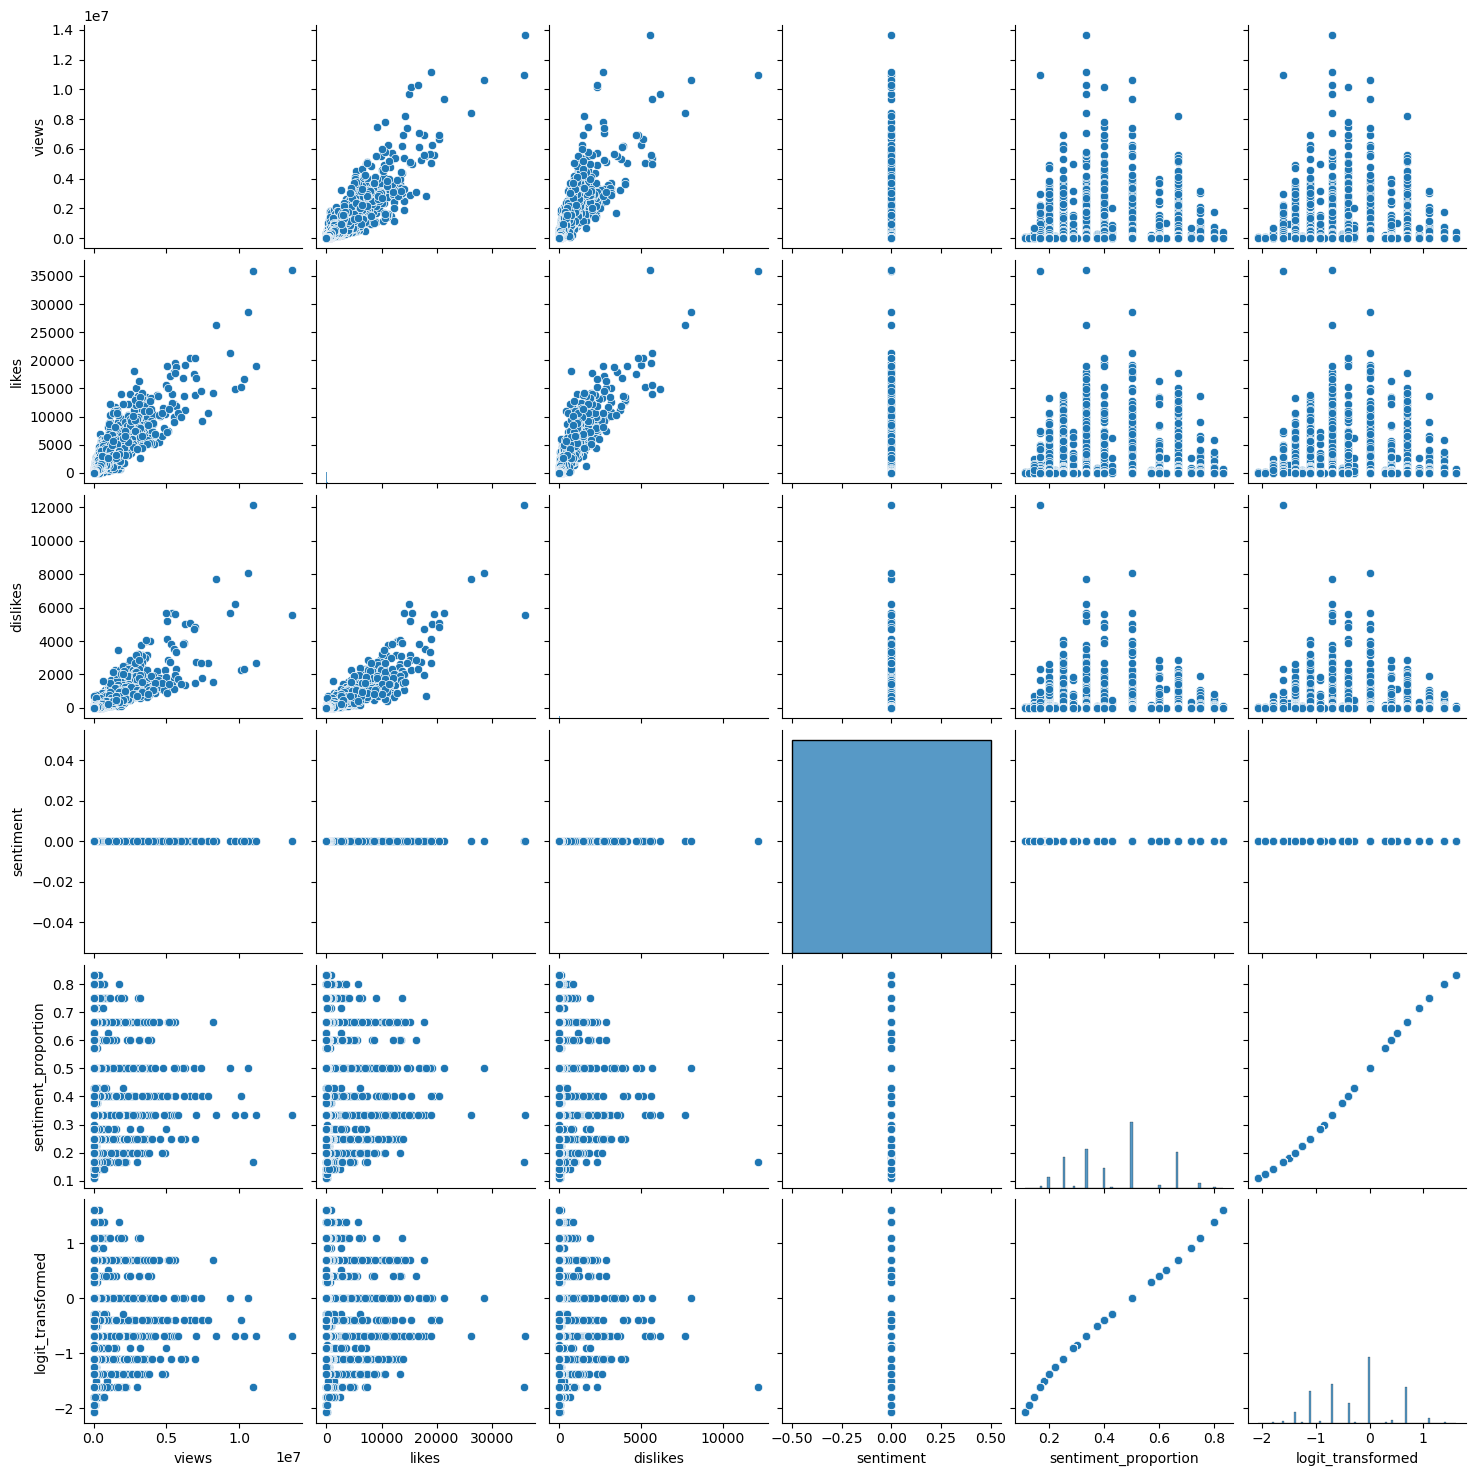

In [59]:
sns.pairplot(prop_df)

Note for when I'm home: consider the implications of a scale that involves most of the entries being at one or the other end
- Could this be weighed better?
    - Maybe take averages for sentiment score?
    - Maybe make it more complex of a calculation when creating the sentiment scores?
- Log func doesn't seem to do much once extremities are removed (expected)

- Also, check out the nrc lexicon. adding words may actually be ezpz with a lexicon simpler than vader

ALSO, consider running separate analyses on the binary distribution (1.0 vs 0.0) and the continuous distribution (the numbers we get in between that form the standard deviation curve)
or, use non-parametric methods which do not assume a normal distribution!!! probably this one